In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/09_groups.csv")
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [3]:
bad_ids = pd.read_csv('data/bad_ids.csv')
bad_ids.head()

,Unnamed: 0,id_card
0,0,806096
1,1,1438102
2,2,72344
3,3,427981
4,4,1528414


### Remove Bad Ids

In [4]:
mask = df['id_card'].isin(set(bad_ids['id_card']))
df = df[mask]
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
24,2020-09-01 19:47:25,1116589,0.0,563138,143,20,1.0,104.0,0,10004
45,2020-09-01 20:46:41,3325885,0.0,526601,158,15385,1.0,57.0,0,10004
49,2020-09-01 19:47:25,1116589,0.0,563138,173,379,1.0,52.0,0,10091
54,2020-09-01 13:24:31,11905080,0.0,1325891,173,271,1.0,52.0,0,10091
65,2020-09-01 14:57:03,7385811,5577295.0,246018,173,0,1.0,52.0,0,10091


### Task1
$H_0$ : Buying discounted items depend on the average order total

We use pearson correlation between the average order sum, and the discount scalar

In [5]:
avg = df.groupby('id_doc')['sum'].mean().to_list()
discount = df.groupby("id_doc")['is_green'].sum().to_list()

In [6]:
from scipy.stats import pearsonr
pearsonr(discount, avg)

(-0.13299776439641908, 0.0)

### Outcome
We reject $H_0$ because Pearson coefficient is negative, but it should be positive to accept $H_0$.

### Task2
Prove that the frequency of shopping grows around the wage taking days (1-6 days of each month, 20 -26 days of each month)

In [7]:
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
q = df.groupby(by=[df.index.day])['id_doc'].sum()
q.head()

date
1    1354779387232
2    1376128322545
3    1394465453823
4    1454361283120
5    1345409968530
Name: id_doc, dtype: int64

### Outcome
The plot is self evident, we see spikes in the cart during days 1-6 and 20-26

<AxesSubplot:xlabel='date'>

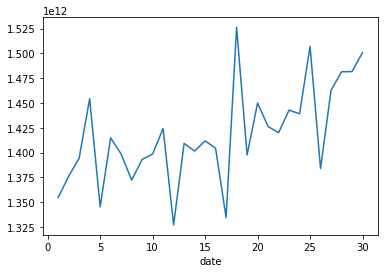

In [8]:
q.plot()

### Task 3
Define such cohort existence:

* Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
* Average purchase sum - The customers that usually spend the same amount of money 
* Usual cart - The customers grouped by the product groups

### Frequent Buyers
Buyers who are in the top 10 percentile

In [9]:
freq = df.groupby('id_card')['id_doc'].apply(len)
freq[freq > freq.quantile(0.9)]

id_card
19         445
191        310
232        275
661        315
749        343
          ... 
1847075    264
1899400    274
1900101    288
1902443    289
1905739    261
Name: id_doc, Length: 2375, dtype: int64

### Average Purchase Sum
Buyers with less than 15 rub standard deviation (~250 ruble variance)

In [10]:
g = df.groupby(['id_doc', 'id_card']).agg({'sum':'sum'}).reset_index()
deviations = g.groupby('id_card')['sum'].std()
deviations.describe()

count    23808.000000
mean       406.692418
std        518.648980
min          0.000000
25%        178.990960
50%        278.048636
75%        437.142204
max       9755.330006
Name: sum, dtype: float64

In [11]:
filtered = deviations[deviations < 15]
filtered.describe()

count    22.000000
mean      6.071582
std       4.948296
min       0.000000
25%       1.684683
50%       5.221984
75%      10.258740
max      14.372543
Name: sum, dtype: float64

### Usual Cart

In [12]:
usual = df.groupby('id_group')['id_card'].unique()
usual.head()

id_group
-9999     [610253, 1359766, 246018, 1325891, 1240383, 88...
 10004    [563138, 526601, 676090, 125891, 238439, 16830...
 10005    [590, 125891, 1359766, 883386, 308685, 79997, ...
 10008    [163657, 590, 563138, 246109, 1359766, 217393,...
 10012    [897476, 106881, 812202, 1272994, 1116917, 119...
Name: id_card, dtype: object